<a href="https://colab.research.google.com/github/magalaReuben/Enimilo_plant_Disease_trainer_Notebboks/blob/main/CropPestAndDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#collecting the dataset
!mkdir CropPestAndDiseaseDataset && cd CropPestAndDiseaseDataset && wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/bwh3zbpkpv-1.zip

--2023-07-04 15:18:00--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/bwh3zbpkpv-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.92.17.130, 52.218.106.120, 52.218.28.184, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.92.17.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8442730448 (7.9G) [application/zip]
Saving to: ‘bwh3zbpkpv-1.zip’

bwh3zbpkpv-1.zip    100%[===================>]   7.86G  29.4MB/s    in 4m 34s  

2023-07-04 15:22:35 (29.4 MB/s) - ‘bwh3zbpkpv-1.zip’ saved [8442730448/8442730448]



In [ ]:
!unzip /content/CropPestAndDiseaseDataset/bwh3zbpkpv-1.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Tomato/leaf blight/leaf blight1304_.jpg  
  inflating: Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Tomato/leaf blight/leaf blight1307_.jpg  
  inflating: Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Tomato/leaf blight/leaf blight1305_.jpg  
  inflating: Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Tomato/leaf blight/leaf blight1303_.jpg  
  inflating: Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Tomato/leaf blight/leaf blight1302_.jpg  
  inflating: Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Tomato/leaf blight/leaf blight1301_.jpg  
  inflating: Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Tomato/leaf blight/leaf blight1308_.jpg  
  inflating: Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Tomato/leaf blight/leaf

***This Section is for the training process of the model for detecting issues with Cashew crop***

If it works for the curshew crop, the whole procedure will be the same for all the other crop dataset. ☺️

* Since this is a larger dataset, using plane CNN might take alot of time to achieve a high score and also will require much computational resources not provided by collab, I am going to use EfficientNetV2
* I will use a pretrained model provided by timm, a popular library for computer vision tasks.

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import math
import time
import random
import gc
import cv2
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold

# Image augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Modeling
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print(f'PyTorch version {torch.__version__}')
print(f'Albumentations version {A.__version__}')

PyTorch version 2.0.1+cu118
Albumentations version 1.2.1


In [ ]:
#setting cofigurations: helpful in maintaining a clear and organized workflow.
RUN_EDA = True
RUN_TRAINING = True
TRAIN_ALL = False # If true, train with all data and output a single model. If False, run cross-validation and output multiple models.
FOLD_NUM = 3 # For cross-validation
EPOCHS = 5 # Training cycle
RUN_INFERENCE = False

# Directory setting
DATA_DIR = '/content/Dataset for Crop Pest and Disease Detection/CCMT Dataset-Augmented/Cashew'
MODEL_DIR = '/content/working/'
CSV_SAVE_DIR = '/content/working/'
IMG_SAVE_DIR = '/content/working/'

# PyTorch variables
SEED = 42
NUM_CLASSES = 5
NUM_WORKERS = 2
BATCH_SIZE = 8

LR = 0.0001

In [ ]:
# helper functions
# coz am too lazy to write new ones 😪💤 e.g create_gallery
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
# Set seed
seed_everything(SEED)

def show_gpu_memory(device):
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(device) / 1024 / 1024:.2f} MB")
    print(f"Cached GPU memory: {torch.cuda.memory_cached(device) / 1024 / 1024:.2f} MB")


def load_img(path):
    try:
        img_bgr = cv2.imread(path)
        #print(f"Hello Reuben:--> {path}")
        if img_bgr is None:
            raise ValueError(f"Failed to read image: {path}")
        img_rgb = img_bgr[:, :, ::-1]
        return img_rgb.astype(np.float32)
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

def create_gallery(array, ncols=3):
    """Display multiple images in a gallery style.
    Source: https://www.amazon.co.jp/Data-Analysis-Machine-Learning-Kaggle-ebook/dp/B09F3STL34/

    Args:
        array (numpy.ndarray): array of images.
        ncols (int, optional): Num of columns. Defaults to 3.

    Returns:
        numpy.ndarray: One concatenated image.
    """
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows * ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
        .swapaxes(1,2)
        .reshape(height*nrows, width*ncols, intensity))
    return result

def show_validation_score(train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, save=False, save_dir=IMG_SAVE_DIR, save_name='classification_validation_score.png'):
    fig = plt.figure(figsize=(15,15))
    for i in range(FOLD_NUM):
        train_acc = train_acc_list[i]
        train_loss = train_loss_list[i]
        valid_acc = valid_acc_list[i]
        valid_loss = valid_loss_list[i]

        ax = fig.add_subplot(math.ceil(np.sqrt(FOLD_NUM))*2, math.ceil(np.sqrt(FOLD_NUM))*2, (i*2)+1, title=f'Fold {i+1}')
        ax.plot(range(EPOCHS), train_acc, c='orange', label='train')
        ax.plot(range(EPOCHS), valid_acc, c='blue', label='valid')
        ax.set_xlabel('epoch')
        ax.set_ylabel('accuracy')
        ax.legend()

        ax = fig.add_subplot(math.ceil(np.sqrt(FOLD_NUM))*2, math.ceil(np.sqrt(FOLD_NUM))*2, (i*2)+2, title=f'Fold {i+1}')
        ax.plot(range(EPOCHS), train_loss, c='orange', label='train')
        ax.plot(range(EPOCHS), valid_loss, c='blue', label='valid')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend()

    plt.tight_layout()
    if save:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_dir+save_name)
    else:
        plt.show()

In [ ]:
# creating json file for our label_num_to_disease
import json

# Data to be written
dictionary = {
    "0": "anthracnose3102",
    "1": "gumosis1714",
    "2": "healthy5877",
    "3": "leaf miner3466",
    "4": "red rust4751"
}

test_dictionary = {
    "0": "anthracnose",
    "1": "gumosis",
    "2": "healthy",
    "3": "leaf miner",
    "4": "red rust"
}

# Serializing json
json_object = json.dumps(dictionary, indent=4)

# Writing to sample.json
with open("/content/Dataset for Crop Pest and Disease Detection/CCMT Dataset-Augmented/Cashew/label_num_to_disease_map.json", "w") as outfile:
    outfile.write(json_object)

In [ ]:
# creating csv file for trainig from our data and then re suffling the file to create randomness
import os
import csv
import shutil


def create_csv_file(dictionary, train_set_dir, output_file, created_train_set):
    data = []
    os.makedirs(created_train_set, exist_ok=True)
    for label, disease in dictionary.items():
        folder_path = os.path.join(train_set_dir, disease)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            shutil.copy(image_path, created_train_set)
            new_image_path = os.path.join(created_train_set, filename)
            data.append([new_image_path, label])

    random.shuffle(data)

    with open(output_file, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['image_id', 'label'])

        for row in data:
            csv_writer.writerow(row)


created_train_set = "/content/Dataset for Crop Pest and Disease Detection/CCMT Dataset-Augmented/Cashew/train_images"
test_set_dir = "/content/Dataset for Crop Pest and Disease Detection/CCMT Dataset-Augmented/Cashew/train_set"
output_file = "/content/Dataset for Crop Pest and Disease Detection/CCMT Dataset-Augmented/Cashew/train.csv"
create_csv_file(dictionary, test_set_dir, output_file, created_train_set)

In [ ]:
df = pd.read_csv(DATA_DIR + '/train.csv')
df.head()

image_id  label
0  /content/Dataset for Crop Pest and Disease Det...      3
1  /content/Dataset for Crop Pest and Disease Det...      2
2  /content/Dataset for Crop Pest and Disease Det...      2
3  /content/Dataset for Crop Pest and Disease Det...      2
4  /content/Dataset for Crop Pest and Disease Det...      2

In [ ]:
df.tail()

image_id  label
18905  /content/Dataset for Crop Pest and Disease Det...      2
18906  /content/Dataset for Crop Pest and Disease Det...      2
18907  /content/Dataset for Crop Pest and Disease Det...      2
18908  /content/Dataset for Crop Pest and Disease Det...      0
18909  /content/Dataset for Crop Pest and Disease Det...      1

In [ ]:
#checking for distribution of labels
if RUN_EDA:
    print(df['label'].value_counts())
else:
    print('RUN_EDA is False')

2    5877
4    4751
3    3466
0    3102
1    1714
Name: label, dtype: int64


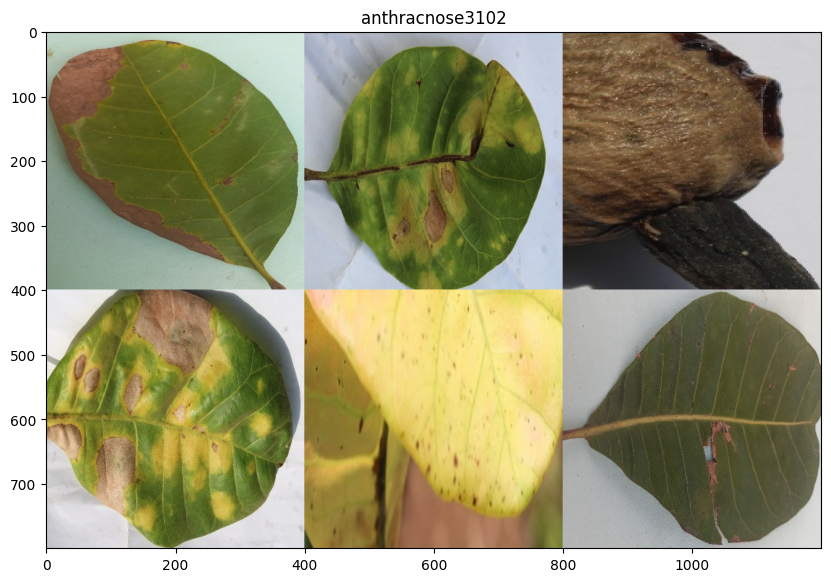

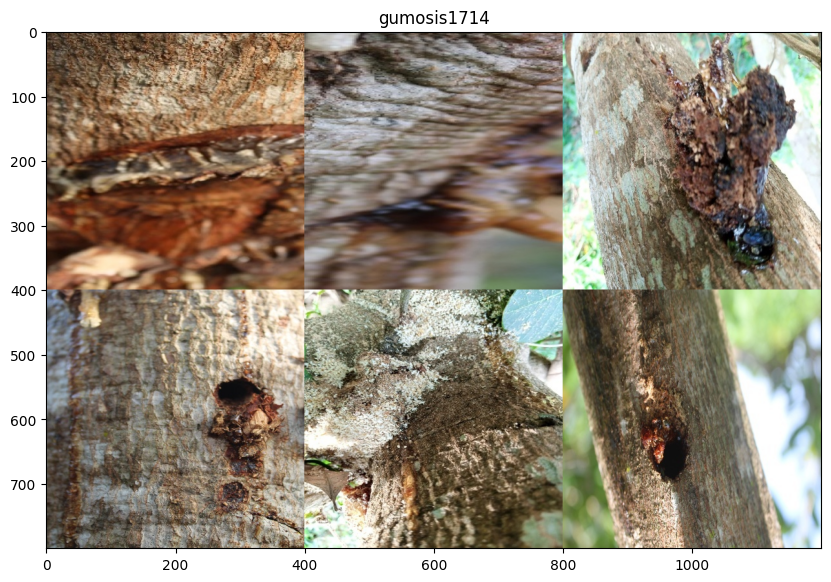

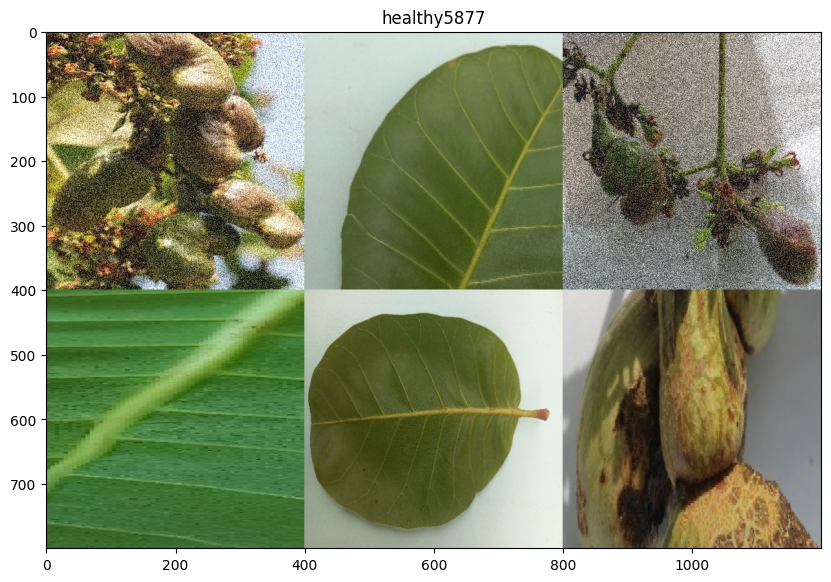

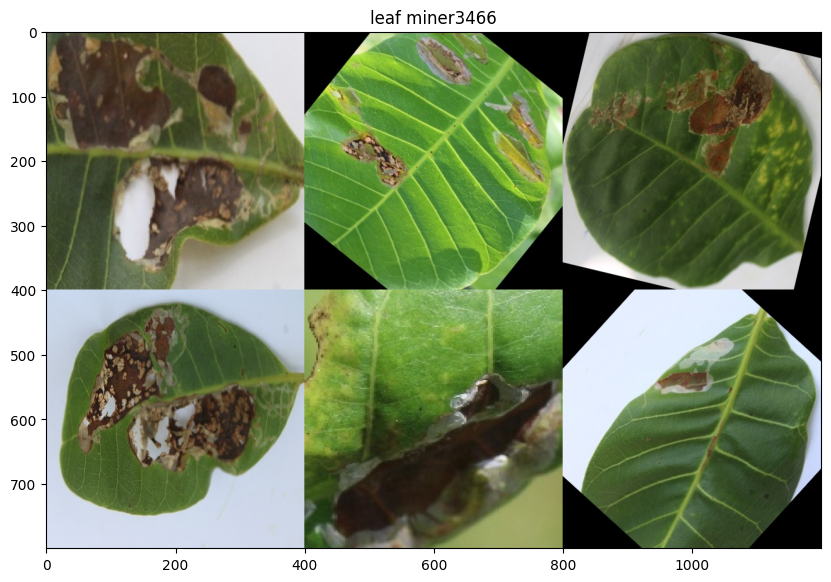

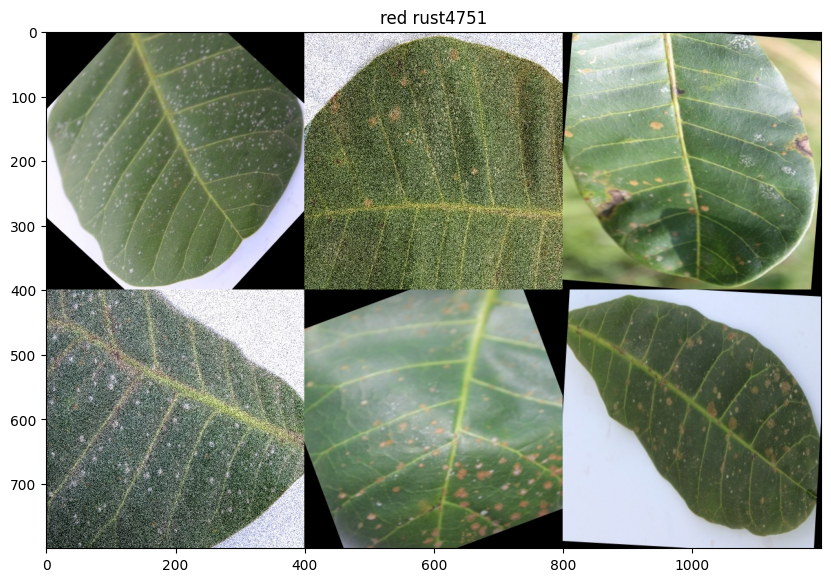

In [ ]:

if RUN_EDA:
    for _, disease in dictionary.items():
      print('\n')
      img_names = Path(DATA_DIR+'/train_set/'+ disease + '/').glob('*.JPG')
      img_list = []
      for i, img_name in enumerate(img_names):
          img_list.append(load_img(img_name.as_posix()))
          #print(f'{img_name.name}, label: {df[df["image_id"]==img_name.name]["label"].to_numpy()}')
          if i == 5:
              break
      plt.figure(figsize=(10,10))
      plt.title(disease)
      plt.imshow(create_gallery(np.array(img_list), ncols=3))
      plt.show()
else:
    print('RUN_EDA is False')

In [ ]:
# checking image shape
if RUN_EDA:
    for _, disease in dictionary.items():
      img_shape = set()
      img_ext = set()
      img_names = Path(DATA_DIR+'/train_set/'+ disease + '/').glob('*')
      pbar = tqdm(img_names, total=len(df))
      for img_name in pbar:
          img = load_img(img_name.as_posix())
          img_shape.add(img.shape)
          img_ext.add(img_name.suffix)
      print(f'Disease: {disease}')
      print(f'Image shapes are {img_shape}.')
      print(f'Image extensions are {img_ext}.')
else:
    print('RUN_EDA is False')

  0%|          | 0/18910 [00:00<?, ?it/s]

Disease: anthracnose3102
Image shapes are {(400, 400, 3), (312, 400, 3)}.
Image extensions are {'.JPG'}.


  0%|          | 0/18910 [00:00<?, ?it/s]

Disease: gumosis1714
Image shapes are {(400, 400, 3)}.
Image extensions are {'.JPG'}.


  0%|          | 0/18910 [00:00<?, ?it/s]

Disease: healthy5877
Image shapes are {(320, 235, 3), (249, 364, 3), (333, 283, 3), (306, 211, 3), (258, 307, 3), (311, 355, 3), (292, 369, 3), (352, 269, 3), (318, 333, 3), (239, 355, 3), (285, 370, 3), (400, 400, 3), (263, 358, 3), (299, 356, 3), (332, 379, 3), (293, 382, 3), (323, 235, 3), (260, 355, 3), (262, 369, 3), (334, 279, 3), (391, 269, 3), (309, 239, 3), (290, 223, 3), (274, 400, 3), (245, 160, 3), (259, 318, 3)}.
Image extensions are {'.JPG'}.


  0%|          | 0/18910 [00:00<?, ?it/s]

Disease: leaf miner3466
Image shapes are {(292, 400, 3), (296, 369, 3), (222, 308, 3), (274, 230, 3), (238, 288, 3), (254, 343, 3), (310, 358, 3), (257, 263, 3), (239, 324, 3), (312, 346, 3), (322, 293, 3), (247, 251, 3), (234, 313, 3), (269, 292, 3), (234, 337, 3), (317, 375, 3), (260, 311, 3), (400, 400, 3), (214, 244, 3), (261, 321, 3), (291, 327, 3), (298, 227, 3), (321, 354, 3), (210, 289, 3), (206, 276, 3), (261, 312, 3), (203, 272, 3), (318, 400, 3), (335, 400, 3), (291, 289, 3), (314, 400, 3)}.
Image extensions are {'.JPG'}.


  0%|          | 0/18910 [00:00<?, ?it/s]

Disease: red rust4751
Image shapes are {(400, 400, 3)}.
Image extensions are {'.JPG'}.


  0%|          | 0/18910 [00:00<?, ?it/s]

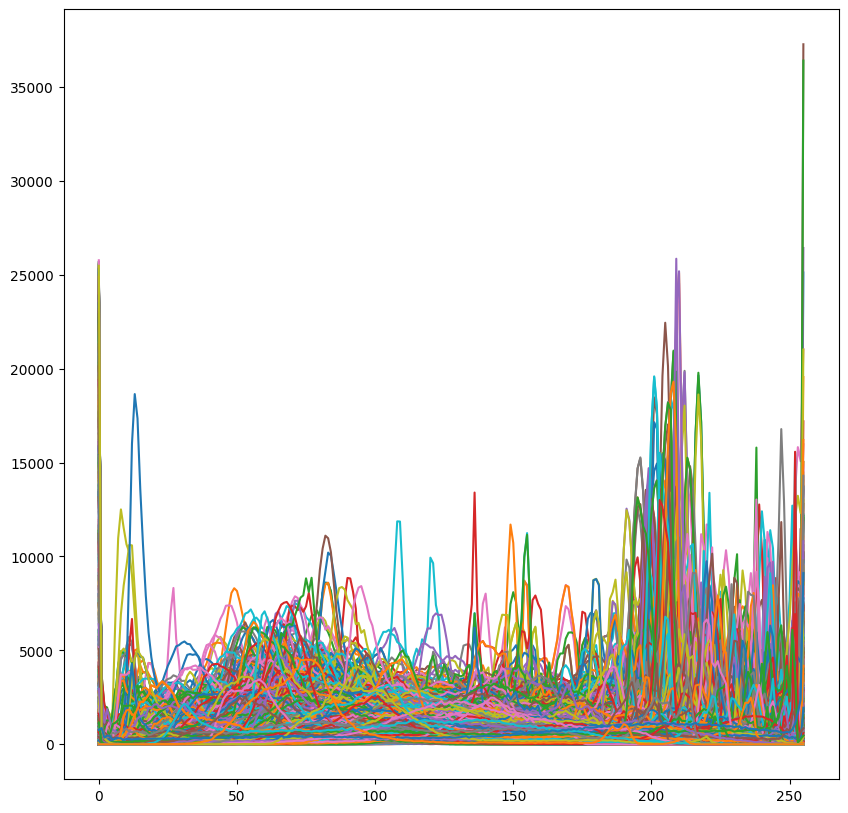

  0%|          | 0/18910 [00:00<?, ?it/s]

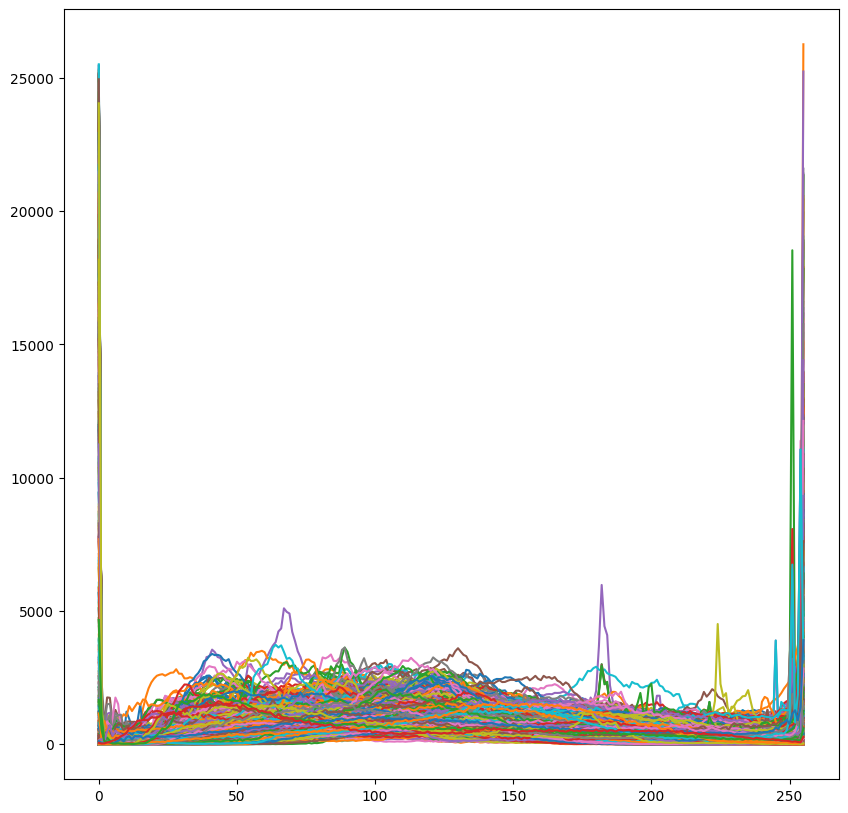

  0%|          | 0/18910 [00:00<?, ?it/s]

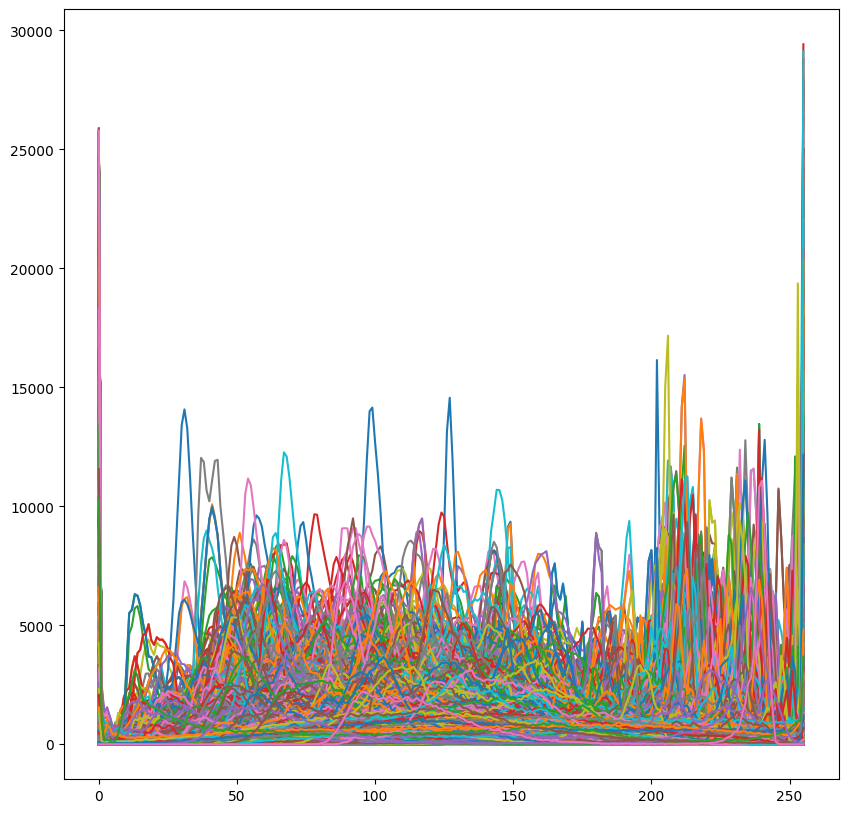

  0%|          | 0/18910 [00:00<?, ?it/s]

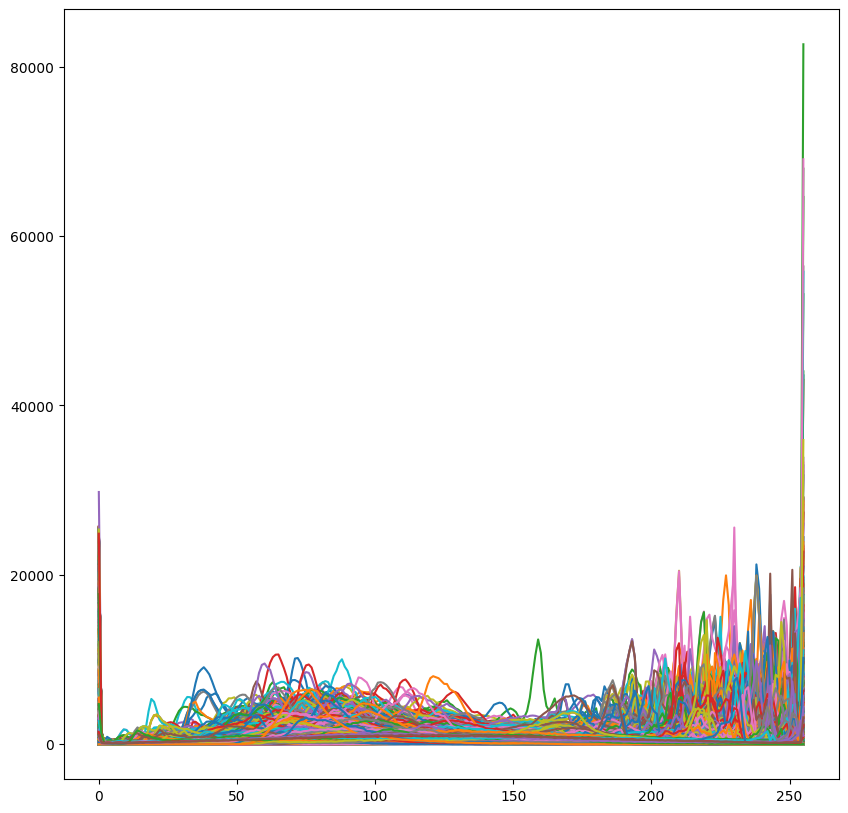

  0%|          | 0/18910 [00:00<?, ?it/s]

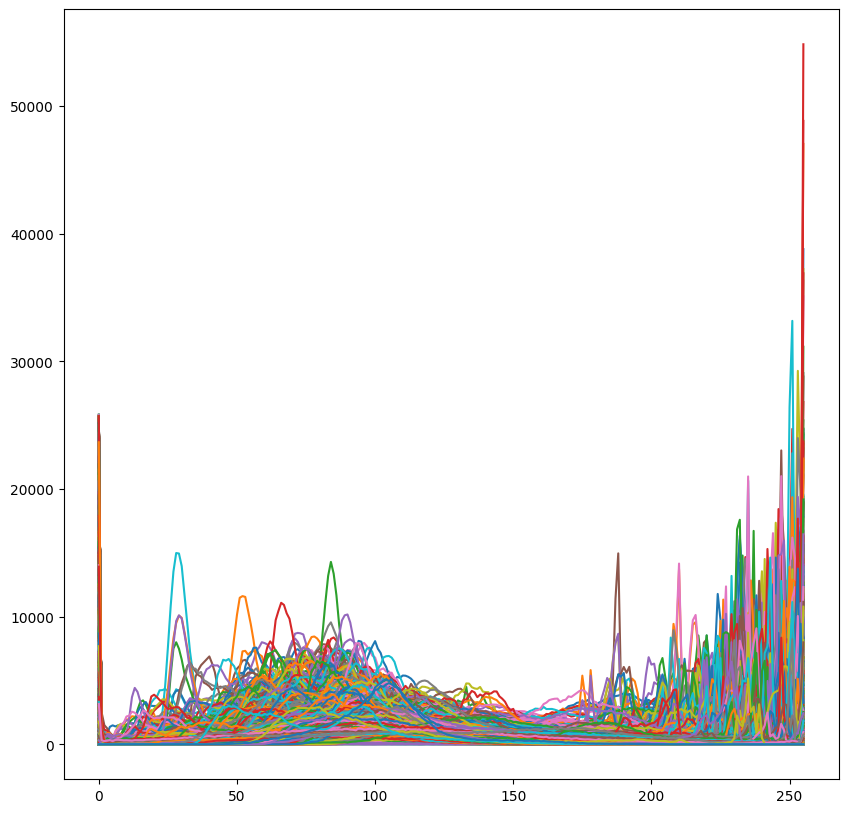

In [ ]:
# plotting graphs
if RUN_EDA:
    for _, disease in dictionary.items():
      img_names = Path(DATA_DIR+'/train_set/'+ disease + '/').glob('*')
      plt.figure(figsize=(10,10))
      pbar = tqdm(img_names, total=len(df))
      for img_name in pbar:
          img = load_img(img_name.as_posix())
          hist = cv2.calcHist([img],[0],None,[256],[0,256])
          plt.plot(hist)
      plt.show()
else:
    print('RUN_EDA is False')

In [ ]:
# transformations and augmentations

# Image Augmentation
def transform_train():
    transform = [
        A.Resize(512,512,p=1),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.CoarseDropout(p=0.5),
        ToTensorV2(p=1.0)
    ]
    return A.Compose(transform)


# Validation (and test) images should only be resized.
def transform_valid():
    transform = [
        A.Resize(512,512,p=1),
        ToTensorV2(p=1.0)
    ]
    return A.Compose(transform)

Will use this cell (down below) to create testing set later

In [ ]:
# Dont run this cell I realised later its unnessecary
# create train_data_set and test_set
# will use it to create testing set
import shutil
import os

# creating training dataset
# def create_training_dataset(train_set_dir, created_train_set):
#   os.makedirs(created_train_set, exist_ok=True)
#   for label, disease in dictionary.items():
#           folder_path = os.path.join(train_set_dir, disease)
#           for filename in os.listdir(folder_path):
#               image_path = os.path.join(folder_path, filename)
#               shutil.copy(image_path, created_train_set)

# creating testing dataset
# def create_testing_dataset(test_set_dir, created_test_set):
#   os.makedirs(created_test_set, exist_ok=True)
#   for label, disease in test_dictionary.items():
#           folder_path = os.path.join(test_set_dir, disease)
#           for filename in os.listdir(folder_path):
#               image_path = os.path.join(folder_path, filename)
#               shutil.copy(image_path, created_test_set)



# train_set_dir = "/content/Dataset for Crop Pest and Disease Detection/CCMT Dataset-Augmented/Cashew/train_set"
# created_train_set = "/content/Dataset for Crop Pest and Disease Detection/CCMT Dataset-Augmented/Cashew/train_images"
# test_set_dir = "/content/Dataset for Crop Pest and Disease Detection/CCMT Dataset-Augmented/Cashew/test_set"
# created_test_set = "/content/Dataset for Crop Pest and Disease Detection/CCMT Dataset-Augmented/Cashew/test_images"

# create_training_dataset(train_set_dir, created_train_set)
# create_testing_dataset(test_set_dir, created_test_set)

In [ ]:
# Dataset
class CropDataset(Dataset):
    def __init__(self, df, data_root, transforms=None, give_label=True):
        """Performed only once when the Dataset object is instantiated.
        give_label should be False for test data
        """
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.data_root = data_root
        self.transforms = transforms
        self.give_label = give_label

        if give_label == True:
            self.labels = self.df['label'].values

    def __len__(self):
        """Function to return the number of records in the dataset
        """
        return self.df.shape[0]

    def __getitem__(self, index):
        """Function to return samples corresponding to a given index from a dataset
        """
        # get labels
        if self.give_label:
            target = self.labels[index]

        # Load images
        #img  = load_img(f'{self.data_root}/{self.df.loc[index]["image_id"]}').astype(np.float32)
        img  = load_img(f'{self.df.loc[index]["image_id"]}')
        # img /= 255.0 # Normalization

        # Transform images
        if self.transforms:
            img = self.transforms(image=img)['image']

        if self.give_label == True:
            return img, target
        else:
            return img

In [ ]:
# DataLoader
# will look into this later
def create_dataloader(df, trn_idx, val_idx):
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)

    # Dataset
    train_datasets = CropDataset(train_, DATA_DIR +' /train_images/', transforms=transform_train())
    valid_datasets = CropDataset(valid_, DATA_DIR + '/test_images/', transforms=transform_valid())

    # Data Loader
    train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, multiprocessing_context='fork')
    valid_loader = DataLoader(valid_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False, multiprocessing_context='fork')

    return train_loader, valid_loader

**Added this table to show pretrained effecientnet models that we might try out in the future incase we get better computing resources coz they are large hence alot of training time but give better accuracy on image tasks since they are initialized with pretrained weights so when we get a better PC we should try them out and see what we get**


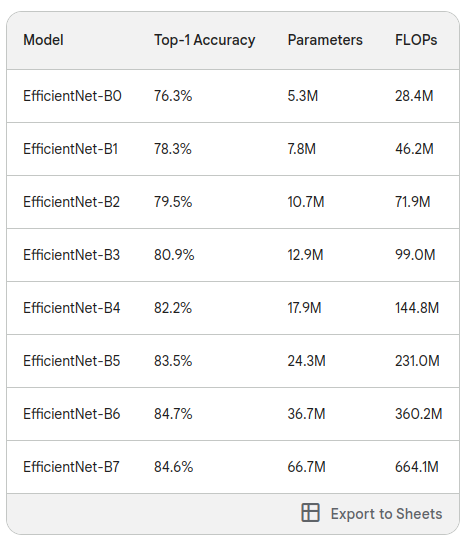

In [ ]:
# will try out EfficientNet-B3 in the future since it gives better accuracy and is already pretrained but takes longer to train since it is larger
# as seen in the table above, we have pretrained efficientnet architectures
# So incase we get a better PC maybe we will try it out

class EfficientNet_V2(nn.Module):
    def __init__(self, n_out):
        super(EfficientNet_V2, self).__init__()
        # Define model
        self.effnet = timm.create_model('efficientnetv2_s', pretrained=False, num_classes=n_out)

    def forward(self, x):
        return self.effnet(x)

In [ ]:
## Training step:
if RUN_TRAINING and (TRAIN_ALL == False):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using {device} device')

    # Cross-validation
    folds = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)\
            .split(np.arange(df.shape[0]), df['label'].to_numpy())

    # For Visualization
    train_acc_list = []
    valid_acc_list = []
    train_loss_list = []
    valid_loss_list = []


    for fold, (trn_idx, val_idx) in enumerate(folds):
        print(f'==========Cross Validation Fold {fold+1}==========')
        # Load Data
        train_loader, valid_loader = create_dataloader(df, trn_idx, val_idx)

        # Load model, loss function, and optimizing algorithm
        model = EfficientNet_V2(NUM_CLASSES).to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=LR)

        # For Visualization
        train_accs = []
        valid_accs = []
        train_losses = []
        valid_losses = []

        # Start training
        best_acc = 0
        for epoch in range(EPOCHS):
            time_start = time.time()
            print(f'==========Epoch {epoch+1} Start Training==========')
            model.train()

            epoch_loss = 0
            epoch_accuracy = 0

            pbar = tqdm(enumerate(train_loader), total=len(train_loader))
            for step, (img, label) in pbar:
                img = img.to(device).float()
                label = label.to(device).long()

                output = model(img)
                loss = loss_fn(output, label)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                acc = (output.argmax(dim=1) == label).float().mean()
                epoch_accuracy += acc / len(train_loader)
                epoch_loss += loss / len(train_loader)

            print(f'==========Epoch {epoch+1} Start Validation==========')
            with torch.no_grad():
                epoch_val_accuracy = 0
                epoch_val_loss = 0
                val_labels = []
                val_preds = []

                pbar = tqdm(enumerate(valid_loader), total=len(valid_loader))
                for step, (img, label) in pbar:
                    img = img.to(device).float()
                    label = label.to(device).long()

                    val_output = model(img)
                    val_loss = loss_fn(val_output, label)

                    acc = (val_output.argmax(dim=1) == label).float().mean()
                    epoch_val_accuracy += acc / len(valid_loader)
                    epoch_val_loss += val_loss / len(valid_loader)

                    val_labels += [label.detach().cpu().numpy()]
                    val_preds += [torch.argmax(val_output, 1).detach().cpu().numpy()]

                val_labels = np.concatenate(val_labels)
                val_preds = np.concatenate(val_preds)

            # print result from this epoch
            exec_t = int((time.time() - time_start)/60)
            print(
                f'Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} / Exec time {exec_t} min\n'
            )

            # For visualization
            train_accs.append(epoch_accuracy.cpu().numpy())
            valid_accs.append(epoch_val_accuracy.cpu().numpy())
            train_losses.append(epoch_loss.detach().cpu().numpy())
            valid_losses.append(epoch_val_loss.detach().cpu().numpy())

        train_acc_list.append(train_accs)
        valid_acc_list.append(valid_accs)
        train_loss_list.append(train_losses)
        valid_loss_list.append(valid_losses)
        del model, optimizer, train_loader, valid_loader, train_accs, valid_accs, train_losses, valid_losses
        gc.collect()
        torch.cuda.empty_cache()

    show_validation_score(train_acc_list, train_loss_list, valid_acc_list, valid_loss_list)

else:
    print('Cross validation is not performed')

Using cuda device
==========Cross Validation Fold 1==========
==========Epoch 1 Start Training==========


  0%|          | 0/1576 [00:00<?, ?it/s]